In [1]:
import os
import sys

sys.path.append(os.path.abspath('..'))
import modules.io as io
import matplotlib.pyplot as plt
import numpy as np

import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import tensorflow as tf

In [2]:
DATA_KEY    = "VAL"
CONFIG_FILE = '../config/googlenet_c30_train300k_aug10_clean.yaml'
LOAD = True

config      = io.load_yaml(CONFIG_FILE)
config['MODEL_DIR'] = config['MODEL_DIR'].replace('.','..')

SCALE = config['CROP_DIMS']/2*config['SPACING']

In [3]:
import factories.dataset_factory as dataset_factory

data    = dataset_factory.get(config, DATA_KEY)

231it [00:00, 3786.85it/s]
  2%|▏         | 5/231 [00:00<00:04, 49.62it/s]

centering images


100%|██████████| 231/231 [00:02<00:00, 91.68it/s]


In [4]:
import factories.model_factory as model_factory

model = model_factory.get(config)
if LOAD: model.load()

pool 1 Tensor("googlenet/max_pool:0", shape=(?, 79, 79, 64), dtype=float32)
pool_2 Tensor("googlenet/max_pool_1:0", shape=(?, 39, 39, 192), dtype=float32)
pool 3 Tensor("googlenet/max_pool_2:0", shape=(?, 19, 19, 480), dtype=float32)
pool side Tensor("googlenet/avg_pool:0", shape=(?, 5, 5, 833), dtype=float32)
[None, 3200]
[None, 1024]
pool 5 Tensor("googlenet/max_pool_3:0", shape=(?, 9, 9, 833), dtype=float32)
pool final Tensor("googlenet/avg_pool_1:0", shape=(?, 3, 3, 1024), dtype=float32)
[None, 9216]
[None, 1024]
Tensor("googlenet/output/Identity:0", shape=(?, 30), dtype=float32)
Tensor("googlenet/side_output/Identity:0", shape=(?, 30), dtype=float32)
INFO:tensorflow:Restoring parameters from ../results/googlenet_c30_train300k_aug10_clean/model/googlenet


In [5]:
tensor_list = [n.name for n in tf.get_default_graph().as_graph_def().node]
for t in tensor_list:
    print(t)

Placeholder
Placeholder_1
googlenet/input_7x7/random_normal/shape
googlenet/input_7x7/random_normal/mean
googlenet/input_7x7/random_normal/stddev
googlenet/input_7x7/random_normal/RandomStandardNormal
googlenet/input_7x7/random_normal/mul
googlenet/input_7x7/random_normal
googlenet/input_7x7/W
googlenet/input_7x7/W/Assign
googlenet/input_7x7/W/read
googlenet/input_7x7/zeros
googlenet/input_7x7/b
googlenet/input_7x7/b/Assign
googlenet/input_7x7/b/read
googlenet/input_7x7/convolution/dilation_rate
googlenet/input_7x7/convolution
googlenet/input_7x7/add
googlenet/input_7x7/leaky_re_lu/Neg
googlenet/input_7x7/leaky_re_lu/Relu
googlenet/input_7x7/leaky_re_lu/Relu_1
googlenet/input_7x7/leaky_re_lu/Const
googlenet/input_7x7/leaky_re_lu/mul
googlenet/input_7x7/leaky_re_lu/sub
googlenet/max_pool/dilation_rate
googlenet/max_pool
googlenet/input_1x1_r/random_normal/shape
googlenet/input_1x1_r/random_normal/mean
googlenet/input_1x1_r/random_normal/stddev
googlenet/input_1x1_r/random_normal/RandomS

gradients/googlenet/inception_5a/1x1/add_grad/Reshape_1
gradients/googlenet/inception_5a/1x1/add_grad/tuple/group_deps
gradients/googlenet/inception_5a/1x1/add_grad/tuple/control_dependency
gradients/googlenet/inception_5a/1x1/add_grad/tuple/control_dependency_1
gradients/AddN_11
gradients/googlenet/inception_5a/3x3/add_grad/Shape
gradients/googlenet/inception_5a/3x3/add_grad/Shape_1
gradients/googlenet/inception_5a/3x3/add_grad/BroadcastGradientArgs
gradients/googlenet/inception_5a/3x3/add_grad/Sum
gradients/googlenet/inception_5a/3x3/add_grad/Reshape
gradients/googlenet/inception_5a/3x3/add_grad/Sum_1
gradients/googlenet/inception_5a/3x3/add_grad/Reshape_1
gradients/googlenet/inception_5a/3x3/add_grad/tuple/group_deps
gradients/googlenet/inception_5a/3x3/add_grad/tuple/control_dependency
gradients/googlenet/inception_5a/3x3/add_grad/tuple/control_dependency_1
gradients/AddN_12
gradients/googlenet/inception_5a/5x5/add_grad/Shape
gradients/googlenet/inception_5a/5x5/add_grad/Shape_1
gr

googlenet/inception_3b/1x1_pool/W/Adam_1/read
googlenet/inception_3b/1x1_pool/b/Adam/Initializer/zeros
googlenet/inception_3b/1x1_pool/b/Adam
googlenet/inception_3b/1x1_pool/b/Adam/Assign
googlenet/inception_3b/1x1_pool/b/Adam/read
googlenet/inception_3b/1x1_pool/b/Adam_1/Initializer/zeros
googlenet/inception_3b/1x1_pool/b/Adam_1
googlenet/inception_3b/1x1_pool/b/Adam_1/Assign
googlenet/inception_3b/1x1_pool/b/Adam_1/read
googlenet/inception_4a/1x1/W/Adam/Initializer/zeros/shape_as_tensor
googlenet/inception_4a/1x1/W/Adam/Initializer/zeros/Const
googlenet/inception_4a/1x1/W/Adam/Initializer/zeros
googlenet/inception_4a/1x1/W/Adam
googlenet/inception_4a/1x1/W/Adam/Assign
googlenet/inception_4a/1x1/W/Adam/read
googlenet/inception_4a/1x1/W/Adam_1/Initializer/zeros/shape_as_tensor
googlenet/inception_4a/1x1/W/Adam_1/Initializer/zeros/Const
googlenet/inception_4a/1x1/W/Adam_1/Initializer/zeros
googlenet/inception_4a/1x1/W/Adam_1
googlenet/inception_4a/1x1/W/Adam_1/Assign
googlenet/inception

In [6]:
import factories.preprocessor_factory as prepro_factory

preprocessor = prepro_factory.get(config)

In [7]:
import factories.postprocessor_factory as postpro_factory

postprocessor = postpro_factory.get(config)

In [8]:
X = np.array([preprocessor(x) for x in data[0]])
print(X.shape)

(231, 160, 160, 1)


In [9]:
op = tf.get_default_graph().get_tensor_by_name("googlenet/dropout_1/Floor:0")

In [10]:
out = model.sess.run(op, {model.x:X[0][np.newaxis,:,:,:]})
print(out.shape)
print(out[:10])

(1, 9216)
[[1. 1. 1. ... 1. 0. 0.]]


In [11]:
INDEX = 1
N = 10
#model.sample()
contours = []
for i in range(N):
    yhat = model.predict(X[INDEX])
    c    = postprocessor(yhat)
    contours.append(c)

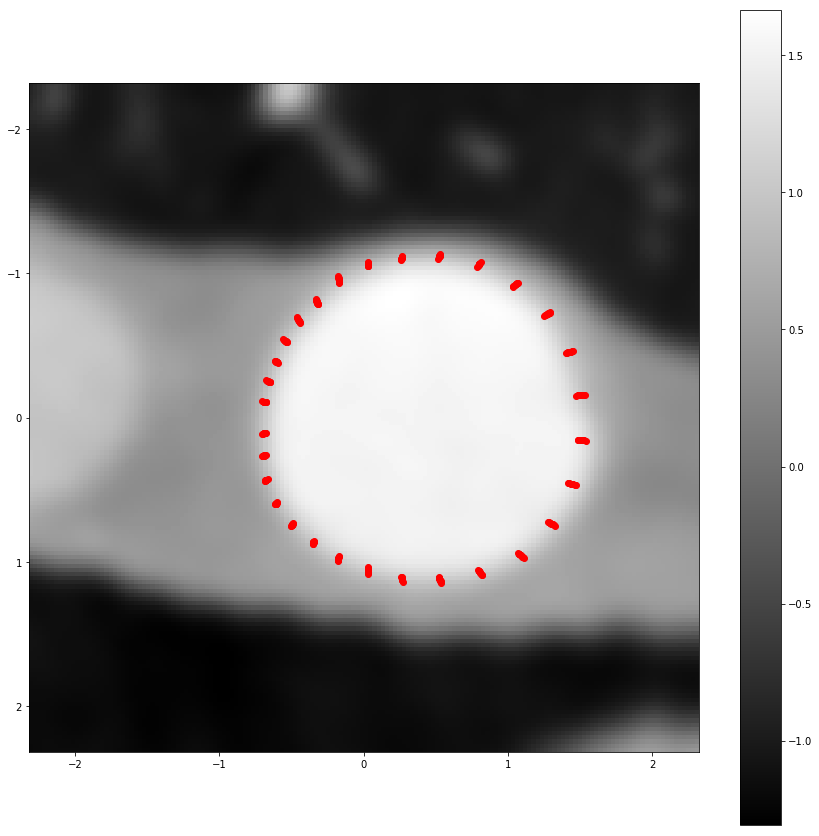

In [12]:
plt.figure(figsize=(15,15))
plt.imshow(X[INDEX,:,:,0], extent=[-SCALE, SCALE, SCALE, -SCALE], cmap='gray')
for c in contours:
    plt.plot(c[:,0], c[:,1], color='r', marker='o', linestyle='')
plt.colorbar()
plt.show()

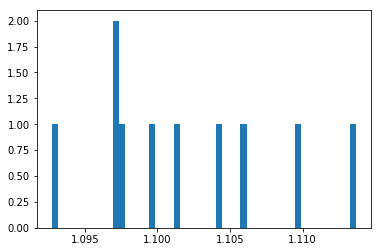

In [13]:
radiuses = []
for c in contours:
    cc = c-np.mean(c,axis=0)
    rs = np.sqrt(np.sum(cc**2,axis=1))
    r  = np.mean(rs)
    radiuses.append(r)

plt.figure()
plt.hist(radiuses, bins=50, label='radius')
plt.show()

In [17]:
from tqdm import tqdm
N = 100
r_means = []
r_stds  = []

for i in tqdm(range(X.shape[0])):
    radiuses = []
    
    for j in range(N):
        yhat = model.predict(X[i])
        c    = postprocessor(yhat)
    
        cc = c-np.mean(c,axis=0)
        rs = np.sqrt(np.sum(cc**2,axis=1))
        r  = np.mean(rs)
        radiuses.append(r)
        
    r_means.append(np.mean(radiuses))
    r_stds.append(np.std(radiuses))
    
r_means = np.array(r_means)
r_stds   = np.array(r_stds)
r_stds_norm = r_stds/r_means

100%|██████████| 231/231 [13:22<00:00,  3.47s/it]


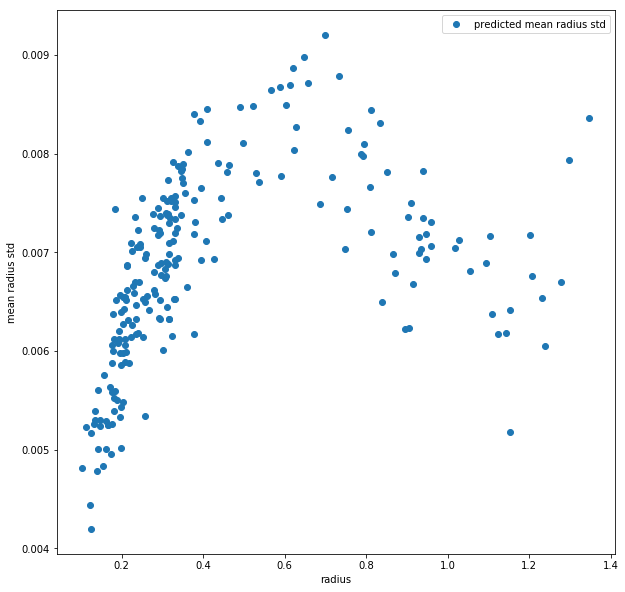

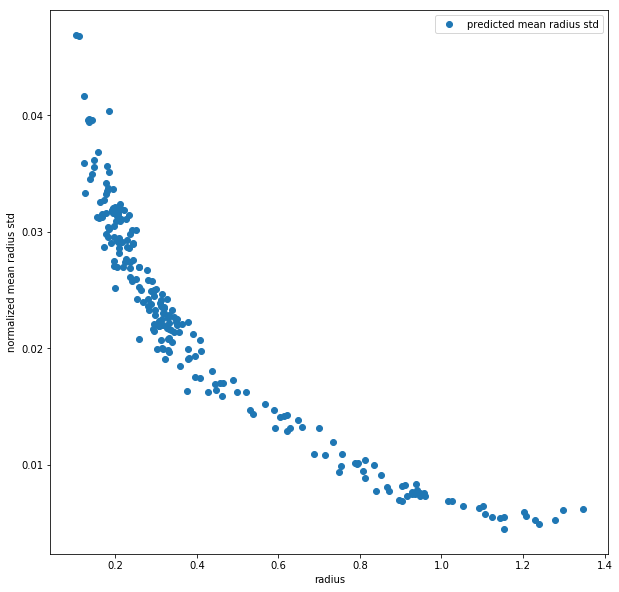

In [18]:
plt.figure(figsize=(10,10))
plt.plot(r_means, r_stds, marker='o', linestyle='', label='predicted mean radius std')
plt.legend()
plt.xlabel('radius')
plt.ylabel('mean radius std')
plt.show()

plt.figure(figsize=(10,10))
plt.plot(r_means, r_stds_norm, marker='o', linestyle='', label='predicted mean radius std')
plt.legend()
plt.xlabel('radius')
plt.ylabel('normalized mean radius std')
plt.show()